In [1]:
from __future__ import division
import numpy
import numpy as np
from astropy.io import fits
import os, sys
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import ephem

In [2]:
#THIS BIT CREATES THE NEW DIRECTORIES REQUIRED FOR THIS CODE. SKIP IF DIRECTORY ALREADY PRESENT
if not os.path.exists('PL_spectra'):
    os.mkdir('PL_spectra')
if not os.path.exists('PL_input_model'):
    os.mkdir('PL_input_model')
if not os.path.exists('PL_fit_model'):
    os.mkdir('PL_fit_model')
if not os.path.exists('Plots'):
    os.mkdir('Plots')
if not os.path.exists('opacities'):
    os.mkdir('opacities')
    
if not os.path.exists('CTA-S'):
    os.mkdir('CTA-S')

if not os.path.exists('CTA-S/PL_events_file'):
    os.mkdir('CTA-S/PL_events_file')

if not os.path.exists('CTA-S/Excess_photons'):
    os.mkdir('CTA-S/Excess_photons')

if not os.path.exists('CTA-S/Fit_results'):
    os.mkdir('CTA-S/Fit_results')

if not os.path.exists('CTA-S/Fit_results/PL_spectra'):
    os.mkdir('CTA-S/Fit_results/PL_spectra')
if not os.path.exists('CTA-S/Fit_results/opacities'):
    os.mkdir('CTA-S/Fit_results/opacities')

if not os.path.exists('Final_results'):
    os.mkdir('Final_results')

In [3]:
#THIS BIT EXTRACTS THE INFO (RA,DEC,SPECTRAL PARAMETERS AND REDSHIFT FROM THE 4LAC CATALOG (agn_pop_4lac_dr2_with_z.dat)
data=numpy.genfromtxt('agn_pop_4lac_dr2_with_z.dat', dtype='str')#final code add
Source_Name=[]
RAJ2000=[]
DECJ2000=[]
Redshift=[]
Pivot_Energy=[]
PL_Flux_Density=[]#units ph / (cm2 MeV s)
PL_Index=[]

all_Source_Name=[]
all_RAJ2000=[]
all_DECJ2000=[]
all_Redshift=[]
all_Pivot_Energy=[]
all_PL_Flux_Density=[]#units ph / (cm2 MeV s)
all_PL_Index=[]


cta_north_lat = 28.71
cta_south_lat = -24.63
    

for i in range(1,len(data)):
    if(data[i][4]=='PowerLaw'):
        all_Source_Name.append(data[i][0])
        all_RAJ2000.append(float(data[i][1]))
        all_DECJ2000.append(float(data[i][2]))
        all_Redshift.append(float(data[i][3]))
        all_Pivot_Energy.append(float(data[i][5]))
        all_PL_Flux_Density.append(float(data[i][6]))
        all_PL_Index.append(float(data[i][7]))

for i in range(len(all_RAJ2000)):
    ra = all_RAJ2000[i]
    dec = all_DECJ2000[i]
    alt_cul_north = (90-numpy.abs(cta_north_lat-dec))
    alt_cul_south = (90-numpy.abs(cta_south_lat-dec))
    zenith_n = ((90-alt_cul_north))
    zenith_s = ((90-alt_cul_south))
    if(0 < zenith_s < 40):
            #south_irf = 'South_z20_50h'
            Source_Name.append(all_Source_Name[i])
            RAJ2000.append(all_RAJ2000[i])
            DECJ2000.append(all_DECJ2000[i])
            Redshift.append(all_Redshift[i])
            Pivot_Energy.append(all_Pivot_Energy[i])
            PL_Flux_Density.append(all_PL_Flux_Density[i])
            PL_Index.append(all_PL_Index[i])

In [4]:
orig_stdout = sys.stdout
f = open('psct_agn_pop_4lac_dr2_with_z_pl.dat', 'w')
sys.stdout = f
print ('Source_Name RAJ2000 DEJ2000 Redshift SpectrumType Pivot_Energy PL_Flux_Density PL_Index')
for i in range(len(Source_Name)):
    print (Source_Name[i],RAJ2000[i],DECJ2000[i],'PowerLaw',Redshift[i],Pivot_Energy[i],PL_Flux_Density[i],PL_Index[i])
sys.stdout = orig_stdout
f.close() 

In [5]:
final_ra_rad=[]
final_dec_rad=[]

ra2=numpy.array(RAJ2000)
dec2=numpy.array(DECJ2000)

for i in range(len(ra2)):
    if(ra2[i]>180):
        ra2[i]=ra2[i]-360
        
for i in range(len(ra2)):
    final_ra_rad.append((ra2[i])*0.0174533)
    final_dec_rad.append((dec2[i])*0.0174533)
    

lon_array = np.arange(0,360)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
RA_gal = eq_array[:,0]
Dec_gal = eq_array[:,1]

final_ra_rad_gal=[]
final_dec_rad_gal=[]

ra2_gal=numpy.array(RA_gal)
dec2_gal=numpy.array(Dec_gal)

for i in range(len(ra2_gal)):
    if(ra2_gal[i]>180):
        ra2_gal[i]=ra2_gal[i]-360


for i in range(len(ra2_gal)):
    final_ra_rad_gal.append((ra2_gal[i])*0.0174533)
    final_dec_rad_gal.append((dec2_gal[i])*0.0174533)

In [6]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

hdul = fits.open('gll_psc_v27.fit')
#hdul.info()

data = hdul[1].data
#print (data)

name=[]
source_type=[]
tevcat=[]
common_name=[]
fermi_significance=[]

for i in range(len(data)):
    name.append(data[i][0])
    fermi_significance.append(data[i][13])
    common_name.append(data[i][-8])
    source_type.append(data[i][-10])
    tevcat.append(data[i][-12])
    
#print (len(name))  
#print (Source_Name)
final_type=[]
final_z=[]
for i in range(len(Source_Name)):
    for j in range(len(name)):
        if(similar(('4FGL '+Source_Name[i]),name[j])>0.95):
            #print (name[j])
            final_type.append(source_type[j])
            final_z.append(Redshift[i])


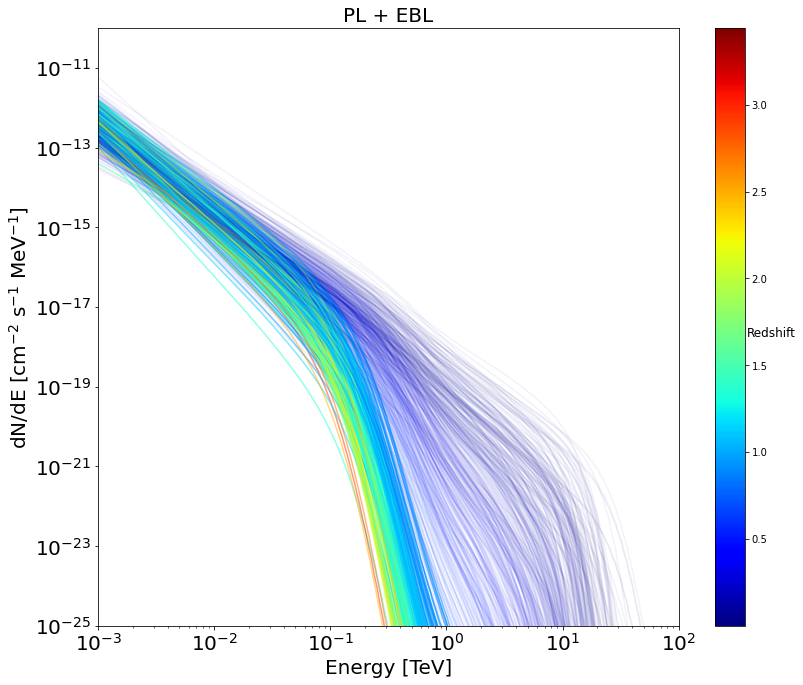

In [7]:
data_ebl=numpy.genfromtxt('dominguez11_cta.dat', dtype='str')#final code add
redshifts_dom=[0.010, 0.020, 0.030, 0.040, 0.050, 0.060, 0.070, 0.080, 0.090, 0.100, 0.110, 0.120, 0.130, 0.140, 0.150, 0.160, 0.170, 0.180, 0.190, 0.200, 0.210, 0.220, 0.230, 0.240, 0.250, 0.260, 0.270, 0.280, 0.290, 0.300, 0.310, 0.320, 0.330, 0.340, 0.350, 0.360, 0.370, 0.380, 0.390, 0.400, 0.410, 0.420, 0.430, 0.440, 0.450, 0.460, 0.470, 0.480, 0.490, 0.500, 0.510, 0.520, 0.530, 0.540, 0.550, 0.560, 0.570, 0.580, 0.590, 0.600, 0.610, 0.620, 0.630, 0.640, 0.650, 0.660, 0.670, 0.680, 0.690, 0.700, 0.710, 0.720, 0.730, 0.740, 0.750, 0.760, 0.770, 0.780, 0.790, 0.800, 0.810, 0.820, 0.830, 0.840, 0.850, 0.860, 0.870, 0.880, 0.890, 0.900, 0.910, 0.920, 0.930, 0.940, 0.950, 0.960, 0.970, 0.980, 0.990, 1.000, 1.010, 1.020, 1.030, 1.040, 1.050, 1.060, 1.070, 1.080, 1.090, 1.100, 1.110, 1.120, 1.130, 1.140, 1.150, 1.160, 1.170, 1.180, 1.190, 1.200, 1.210, 1.220, 1.230, 1.240, 1.250, 1.260, 1.270, 1.280, 1.290, 1.300, 1.310, 1.320, 1.330, 1.340, 1.350, 1.360, 1.370, 1.380, 1.390, 1.400, 1.410, 1.420, 1.430, 1.440, 1.450, 1.460, 1.470, 1.480, 1.490, 1.500, 1.510, 1.520, 1.530, 1.540, 1.550, 1.560, 1.570, 1.580, 1.590, 1.600, 1.610, 1.620, 1.630, 1.640, 1.650, 1.660, 1.670, 1.680, 1.690, 1.700, 1.710, 1.720, 1.730, 1.740, 1.750, 1.760, 1.770, 1.780, 1.790, 1.800, 1.810, 1.820, 1.830, 1.840, 1.850, 1.860, 1.870, 1.880, 1.890, 1.900, 1.910, 1.920, 1.930, 1.940, 1.950, 1.960, 1.970, 1.980, 1.990, 2.000, 2.010, 2.020, 2.030, 2.040, 2.050, 2.060, 2.070, 2.080, 2.090, 2.100, 2.110, 2.120, 2.130, 2.140, 2.150, 2.160, 2.170, 2.180, 2.190, 2.200, 2.210, 2.220, 2.230, 2.240, 2.250, 2.260, 2.270, 2.280, 2.290, 2.300, 2.310, 2.320, 2.330, 2.340, 2.350, 2.360, 2.370, 2.380, 2.390, 2.400, 2.410, 2.420, 2.430, 2.440, 2.450, 2.460, 2.470, 2.480, 2.490, 2.500, 2.510, 2.520, 2.530, 2.540, 2.550, 2.560, 2.570, 2.580, 2.590, 2.600, 2.610, 2.620, 2.630, 2.640, 2.650, 2.660, 2.670, 2.680, 2.690, 2.700, 2.710, 2.720, 2.730, 2.740, 2.750, 2.760, 2.770, 2.780, 2.790, 2.800, 2.810, 2.820, 2.830, 2.840, 2.850, 2.860, 2.870, 2.880, 2.890, 2.900, 2.910, 2.920, 2.930, 2.940, 2.950, 2.960, 2.970, 2.980, 2.990, 3.000, 3.010, 3.020, 3.030, 3.040, 3.050, 3.060, 3.070, 3.080, 3.090, 3.100, 3.110, 3.120, 3.130, 3.140, 3.150, 3.160, 3.170, 3.180, 3.190, 3.200, 3.210, 3.220, 3.230, 3.240, 3.250, 3.260, 3.270, 3.280, 3.290, 3.300, 3.310, 3.320, 3.330, 3.340, 3.350, 3.360, 3.370, 3.380, 3.390, 3.400, 3.410, 3.420, 3.430, 3.440, 3.450, 3.460, 3.470, 3.480, 3.490, 3.500, 3.510, 3.520, 3.530, 3.540, 3.550, 3.560, 3.570, 3.580, 3.590, 3.600, 3.610, 3.620, 3.630, 3.640, 3.650, 3.660, 3.670, 3.680, 3.690, 3.700, 3.710, 3.720, 3.730, 3.740, 3.750, 3.760, 3.770, 3.780, 3.790, 3.800, 3.810, 3.820, 3.830, 3.840, 3.850, 3.860, 3.870, 3.880, 3.890, 3.900, 3.910, 3.920, 3.930, 3.940, 3.950, 3.960, 3.970, 3.980, 3.990]


energy_dom=[]
for i in range(len(data_ebl)):
    energy_dom.append(float(data_ebl[i][0]))



redshift_final=[]
diff_final=[]
tau_index=[]
for i in range(len(Redshift)):
    for j in range(len(redshifts_dom)):
        if(numpy.abs(Redshift[i] -redshifts_dom[j] )<0.012):
            redshift_final.append(redshifts_dom)
            diff_final.append(numpy.abs(Redshift[i] - redshifts_dom[j]))
            tau_index.append(j)
            break;



plt.figure(figsize=(13,11))
for j in range(len(tau_index)):

    energy_dom=[]
    tau_dom=[]
    for i in range(len(data_ebl)):
        energy_dom.append(float(data_ebl[i][0]))
        tau = data_ebl[i][tau_index[j]]
        tau_dom.append(tau)
    e=[]
    dn_de=[]
    dn_de_opacity=[]
    pe_tev=Pivot_Energy[j]*(1e-6)
    alpha=PL_Index[j]
    #print Source_Name[j]
    #print(cm.hot(Redshift[j]))
    z=Redshift[j]


    norm=PL_Flux_Density[j]
    e2_diff_flux=[]
    for i in range(len(energy_dom)):
            e.append(energy_dom[i])
            attenuation=(float(tau_dom[i]))
            diff_flux=(numpy.exp(-float(tau_dom[i]))*norm*(energy_dom[i]/pe_tev)**(-alpha))
            dn_de.append(diff_flux)
            dn_de_opacity.append(attenuation)


    cmap = cm.jet
    norm = Normalize(vmin=0, vmax=4)




    if(z<1.0):
        plt.plot(e,dn_de,alpha=0.05,c=cm.jet(norm(z)))

    if(z>1.0):
        plt.plot(e,dn_de,alpha=0.5,c=cm.jet(norm(z)))



    orig_stdout = sys.stdout
    f = open('CTA-S/Fit_results/PL_spectra/spectra_pl_%s.dat'%(Source_Name[j]),'w')
    sys.stdout = f

    for c in range(len(e)):
        if(dn_de[c]>7.999e-84):
            print(('{0:5.2f} {1:0.4g}').format((e[c]*1e6),dn_de[c]))

    sys.stdout = orig_stdout
    f.close()
    
    orig_stdout = sys.stdout
    f = open('CTA-S/Fit_results/opacities/opacities_pl_%s.dat'%(Source_Name[j]),'w')
    sys.stdout = f

    for c in range(len(e)):
        if(dn_de_opacity[c]>1e-10):
            print(('{0:5.2f} {1:0.4g}').format((e[c]*1e6),dn_de_opacity[c]))

    sys.stdout = orig_stdout
    f.close()



    orig_stdout = sys.stdout
    f = open('PL_input_model/input_loglaw_pl_%s.xml'%(Source_Name[j]),'w')
    sys.stdout = f

    print('''<?xml version="1.0" standalone="no"?>
            <source_library title="source library">
                <source name="{0}" type="PointSource" tscalc="1">
                    <spectrum type="FileFunction" file="PL_spectra/spectra_pl_{1}.dat">
                        <parameter scale="1.0" name="Normalization" min="0.0" max="1000.0" value="1.0" free="1"/>
                    </spectrum>
                    <spatialModel type="SkyDirFunction">
                        <parameter name="RA" value="{2}" scale="1" min="-360" max="360" free="0" />
                        <parameter name="DEC" value="{3}" scale="1" min="-90" max="90" free="0" />
                    </spatialModel>
                </source>
                <source name="CTABackgroundModel" type="CTAIrfBackground" instrument="CTA">
                    <spectrum type="PowerLaw">
                        <parameter name="Prefactor"   scale="1.0"  value="1.0"  min="1e-3" max="1e+3"   free="1"/>
                        <parameter name="Index"       scale="1.0"  value="0.0"  min="-5.0" max="+5.0"   free="1"/>
                        <parameter name="PivotEnergy" scale="1e6"  value="1.0"  min="0.01" max="1000.0" free="0"/>
                    </spectrum>
                </source>
</source_library>'''.format(Source_Name[j],Source_Name[j],RAJ2000[j],DECJ2000[j]))
    sys.stdout = orig_stdout
    f.close()
    
    
    
    orig_stdout = sys.stdout
    f = open('PL_fit_model/fit_loglaw_pl_%s.xml'%(Source_Name[j]),'w')
    sys.stdout = f

    print('''<?xml version="1.0" standalone="no"?>
            <source_library title="source library">
                <source name="{0}" type="PointSource" tscalc="1">
                    <spectrum type="Multiplicative">
                        <spectrum type="PowerLaw">
                            <parameter name="Prefactor"   scale="1e-11" value="{1}"  min="1e-06" max="1e6" free="1"/>
                            <parameter name="Index"       scale="-1"    value="{2}" min="-5.0"   max="+5.0"   free="1"/>
                            <parameter name="PivotEnergy" scale="1000" value="{3}"  min="0.01" max="1000" free="0" />
                        </spectrum>
                        <spectrum type="Exponential">
                            <spectrum type="FileFunction" file="opacities/opacities_pl_{4}.dat">
                                <parameter scale="-1.0" name="Normalization" min="0.0" max="100.0" value="1.0" free="0"/>
                            </spectrum>
                        </spectrum>
                    </spectrum>
                    <spatialModel type="SkyDirFunction">
                            <parameter free="0" max="360" min="-360" name="RA" scale="1" value="{5}" />
                            <parameter free="0" max="90" min="-90" name="DEC" scale="1" value="{6}" />
                    </spatialModel>
                </source>
                <source name="CTABackgroundModel" type="CTAIrfBackground" instrument="CTA">
                    <spectrum type="PowerLaw">
                            <parameter name="Prefactor"   scale="1.0"  value="1.0"  min="1e-3" max="1e+3"   free="1"/>
                            <parameter name="Index"       scale="1.0"  value="0.0"  min="-5.0" max="+5.0"   free="0"/>
                            <parameter name="PivotEnergy" scale="1e6"  value="1.0"  min="0.01" max="1000.0" free="0"/>
                    </spectrum>
                </source>
</source_library>'''.format(Source_Name[j],PL_Flux_Density[j]*(1e11),PL_Index[j],Pivot_Energy[j]/(1e3),Source_Name[j],RAJ2000[j],DECJ2000[j]))
    sys.stdout = orig_stdout
    f.close()




a=[]
b=[]
for i in range(len(Redshift)):
    a.append(-1)
    b.append(-1)

sc1 = plt.scatter(a, b, c=numpy.array(Redshift), cmap=cm.jet)
cbar=plt.colorbar(sc1)
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('Redshift', rotation=0,fontsize=12)

plt.loglog()
plt.xlim([0.001,100])
plt.ylim([1e-25,1e-10])
plt.title('PL + EBL', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.xlabel('Energy [TeV]', fontsize=20)
plt.ylabel(r'dN/dE [cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]', fontsize=20)
plt.savefig('Plots/pl_extrapolated_spectra.png',dpi=100)
#plt.show()


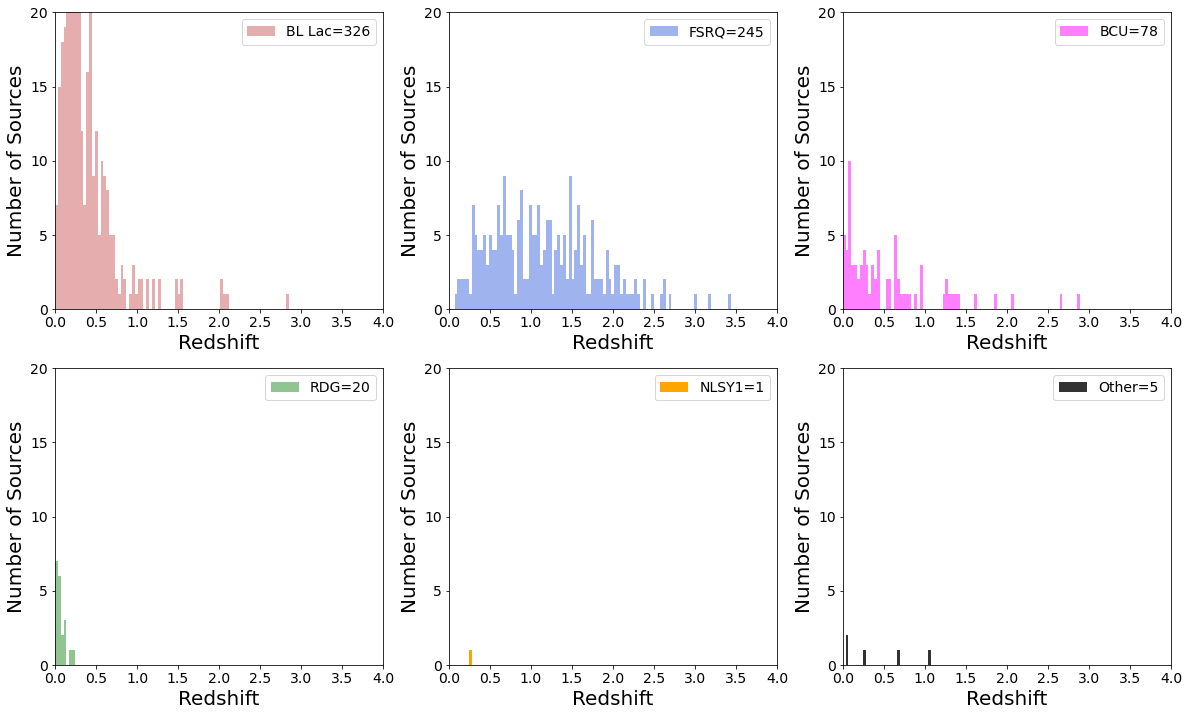

In [8]:
fig=plt.figure(figsize=(20,12))
plt.subplot(2, 3, 1)
plot_z=[]
bl_lac_names=[]
for i in range(len(final_type)):
    if(final_type[i]=='bll' or final_type[i]=='BLL'):
        plot_z.append(final_z[i])  
plt.hist(plot_z, bins=numpy.linspace(0,np.max(final_z),100), fill=True,color='indianred',alpha=0.5,label="BL Lac=%s"%(len(plot_z)))              
plt.ylabel('Number of Sources', fontsize=20)
plt.xlabel('Redshift', fontsize=20)
#plt.xlim([0,numpy.max(plot_z)])
plt.yticks(np.arange(0,21,5))
plt.xlim([0,4])
plt.ylim([0,20])
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(fontsize=14)


plt.subplot(2, 3, 2)
plot_z=[]
for i in range(len(final_type)):
    if(final_type[i]=='fsrq' or final_type[i]=='FSRQ'):
        plot_z.append(final_z[i])  

plt.hist(plot_z, bins=numpy.linspace(0,np.max(final_z),100), fill=True,color='royalblue',alpha=0.5,label="FSRQ=%s"%(len(plot_z)))              
plt.ylabel('Number of Sources', fontsize=20)
plt.xlabel('Redshift', fontsize=20)
plt.xlim([0,4])
plt.ylim([0,20])
plt.yticks(np.arange(0,21,5))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(fontsize=14)



plt.subplot(2, 3, 3)
plot_z=[]
for i in range(len(final_type)):
    if(final_type[i]=='bcu' or final_type[i]=='BCU'):
                    plot_z.append(final_z[i])

plt.hist(plot_z,  bins=numpy.linspace(0,np.max(final_z),100), fill=True,color='magenta',alpha=0.5,label="BCU=%s"%(len(plot_z)))              
plt.ylabel('Number of Sources', fontsize=20)
plt.xlabel('Redshift', fontsize=20)
plt.yticks(np.arange(0,21,5))
plt.xlim([0,4])
plt.ylim([0,20])
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(fontsize=14)



plt.subplot(2, 3, 4)
plot_z=[]
for i in range(len(final_type)):
    if(final_type[i]=='rdg' or final_type[i]=='RDG'):
                    plot_z.append(final_z[i])
plt.hist(plot_z,  bins=numpy.linspace(0,np.max(final_z),100), fill=True,color='forestgreen',alpha=0.5,label="RDG=%s"%(len(plot_z)))           
plt.ylabel('Number of Sources', fontsize=20)
plt.xlabel('Redshift', fontsize=20)
plt.yticks(np.arange(0,21,5))
plt.xlim([0,4])
plt.ylim([0,20])
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(fontsize=14)


plt.subplot(2, 3, 5)
plot_z=[]
for i in range(len(final_type)):
    if(final_type[i]=='nlsy1' or final_type[i]=='NLSY1'):
                    plot_z.append(final_z[i])
plt.hist(plot_z,  bins=numpy.linspace(0,np.max(final_z),100), fill=True,color='orange',alpha=1,label="NLSY1=%s"%(len(plot_z)))              
plt.ylabel('Number of Sources', fontsize=20)
plt.xlabel('Redshift', fontsize=20)
plt.yticks(np.arange(0,21,5))
plt.xlim([0,4])
plt.ylim([0,20])
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(fontsize=14)

plt.subplot(2, 3, 6)
plot_z=[]

for i in range(len(final_type)):
    if(final_type[i]=='agn' or final_type[i]=='AGN' or final_type[i]=='ssrq' or final_type[i]=='css' or final_type[i]=='sey'):
                    plot_z.append(final_z[i])
plt.hist(plot_z, bins=numpy.linspace(0,np.max(final_z),100), fill=True,color='black',alpha=0.8,label="Other=%s"%(len(plot_z)))              
plt.ylabel('Number of Sources', fontsize=20)
plt.xlabel('Redshift', fontsize=20)
plt.yticks(np.arange(0,21,5))
plt.xlim([0,4])
plt.ylim([0,20])
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.legend(fontsize=14)
plt.savefig('Plots/4LAC_known_z.png',dpi=100)
#plt.show()  

In [ ]:
import glob
from os import path

import random
import re

from astropy.io import fits
import time

import gammalib
import ctools
import cscripts

In [ ]:
instance_low = 10
instance_high = 100



data = numpy.genfromtxt('agn_pop_4lac_dr2_with_z.dat', dtype='str')  # insert

all_Source_Name = []
all_RAJ2000 = []
all_DECJ2000 = []
all_Redshift = []
all_Pivot_Energy = []
all_PL_Flux_Density = []  # units ph / (cm2 MeV s)
all_PL_Index = []

cta_north_lat = 28.71
cta_south_lat = -24.63

for i in range(1, len(data)):
    if (data[i][4] == 'PowerLaw'):
        all_Source_Name.append(data[i][0])
        all_RAJ2000.append(float(data[i][1]))
        all_DECJ2000.append(float(data[i][2]))
        all_Redshift.append(float(data[i][3]))
        all_Pivot_Energy.append(float(data[i][5]))
        all_PL_Flux_Density.append(float(data[i][6]))
        all_PL_Index.append(float(data[i][7]))


Source_Name = []
RAJ2000 = []
DECJ2000 = []
Redshift = []
Pivot_Energy = []
PL_Flux_Density = []  # units ph / (cm2 MeV s)
PL_Index = []


for i in range(len(all_RAJ2000)):
    ra = all_RAJ2000[i]
    dec = all_DECJ2000[i]
    alt_cul_north = (90 - numpy.abs(cta_north_lat - dec))
    alt_cul_south = (90 - numpy.abs(cta_south_lat - dec))
    zenith_n = ((90 - alt_cul_north))
    zenith_s = ((90 - alt_cul_south))
    #if (0 < zenith_s < 25):
    if (0 < zenith_s <40):
        # south_irf = 'South_z20_50h'
        Source_Name.append(all_Source_Name[i])
        RAJ2000.append(all_RAJ2000[i])
        DECJ2000.append(all_DECJ2000[i])
        Redshift.append(all_Redshift[i])
        Pivot_Energy.append(all_Pivot_Energy[i])
        PL_Flux_Density.append(all_PL_Flux_Density[i])
        PL_Index.append(all_PL_Index[i])

#source_high = len(Source_Name)
#print (source_high)

# random_source_index=random.randint(0,len(Source_Name))
#source_low = 0
source_high = len(Source_Name)

#caldb = 'prod3b-v2'
#caldb = 'prod5-v0.1'
caldb = 'mult4_zd20_m4'
tmin = 0.0
tmax = 18000  # HALF HOUR FOR DEMO...ADD EXTRA ZERO FOR 5 HOUR SIMULATIONS
emax = 199  # TeV

emin_north = [0.1]  # TeV
emin_south = [0.1]  # TeV

e_gev_n = []
e_gev_s = []

for i in range(len(emin_north)):
    e_gev_n.append(emin_north[i]*(1e3))

for i in range(len(emin_south)):
    e_gev_s.append(emin_south[i]*(1e3))

In [ ]:
# CHANGES THE NUMBER OF INSTANCES SIMULATED...TAKE ABOVE FOR MULTIPLE SIMULATIONS
for j in range(instance_low, instance_high):
    for i in range(source_high):  # CHANGE TO len(Source_Name)
      #if(Model[i] == 'PowerLaw'):
        print(i)
        source_simulating = Source_Name[i]
        ra = RAJ2000[i]
        dec = DECJ2000[i]
        print((''' {0} is being simulated
    its coordinates are RA={1:2.2f}, DEC={2:2.2f}
    and its redshift z={3}''').format(source_simulating, ra,
                                      dec, Redshift[i]))

        cta_north_lat = 28.71
        cta_south_lat = -24.63

        alt_cul_north = []
        alt_cul_south = []
        zenith_n = []
        zenith_s = []
        north_irf = []
        south_irf = []

        alt_cul_north = (90-numpy.abs(cta_north_lat-dec))
        alt_cul_south = (90-numpy.abs(cta_south_lat-dec))

        zenith_n = ((90-alt_cul_north))
        zenith_s = ((90-alt_cul_south))

        if(0 < zenith_s < 40):
            south_irf = 'South_50h'

        print(('The IRFs employed are  CTA S {0}').format(
             south_irf))

        source = Source_Name[i]
        irf_s = south_irf
        zen_s = zenith_s
        # ra=RAJ2000[i]
        # dec=DECJ2000[i]
        seeds = []
        seed = random.randint(1, 1e6)
        if(seed not in seeds):
            seeds.append(seed)
            print(('Simulation instance {0} Seed {1}').format(j, seed))


            for k in range(len(emin_south)):
                print(('Current simulation {0} {1} {2} {3} {4}').format(
                    source, irf_s, emin_south[k], e_gev_s[k], seed))

                evfile = 'CTA-S/PL_events_file/{0}_events_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obssim = ctools.ctobssim()
                obssim['ra'] = ra
                obssim['dec'] = dec
                obssim['rad'] = 3.0
                obssim['tmin'] = tmin  # '2020-01-01T00:00:00'
                obssim['tmax'] = tmax
                obssim['seed'] = seed
                obssim['emin'] = emin_south[k]
                obssim['emax'] = emax
                obssim['caldb'] = caldb
                obssim['irf'] = irf_s
                obssim['nthreads'] = 0
                # obssim['chatter']=2
                obssim['mode'] = 'ql'
                # obssim['logfile']='ctobssim_s_%s.log'%(source)
                obssim['inmodel'] = 'PL_input_model/input_loglaw_pl_{0}.xml'.format(
                    source)
                obssim['outevents'] = evfile
                obssim.execute()

                '''
            file=evfile
            hdul = fits.open(file)
            data = hdul[1].data
            c=0

            for q in range(len(data)):
                     if(data[q][-1]==1):#source
                            c=c+1
            orig_stdout = sys.stdout
            f = open('CTA-S/Excess_photons/excess_photons_s{0}GeV.txt'.format(e_gev_s[k]),'a')
            sys.stdout = f
            print(("{0} {1}").format(file,c))
            sys.stdout = orig_stdout
            f.close()
            hdul.close()


            orig_stdout = sys.stdout
            f = open('CTA-S/Excess_photons/bkg_photons_s{0}GeV.txt'.format(e_gev_s[k]),'a')
            sys.stdout = f
            print(("{0} {1}").format(file,len(data)-c))
            sys.stdout = orig_stdout
            f.close()
            hdul.close()

            '''

                obbin = ctools.ctbin()
                obbin['inobs'] = evfile
                obbin['coordsys'] = 'CEL'
                obbin['proj'] = 'CAR'
                obbin['xref'] = ra
                obbin['yref'] = dec+0.5
                obbin['binsz'] = 0.02
                obbin['nxpix'] = 200
                obbin['nypix'] = 200
                obbin['ebinalg'] = 'LOG'
                obbin['emin'] = emin_south[k]
                obbin['emax'] = emax
                obbin['enumbins'] = 30
                obbin['outobs'] = 'CTA-S/PL_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obbin.execute()

                obexp = ctools.ctexpcube()
                obexp['inobs'] = evfile
                obexp['incube'] = 'CTA-S/PL_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obexp['caldb'] = caldb
                obexp['irf'] = irf_s
                obexp['outcube'] = 'CTA-S/PL_events_file/{0}_expcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obexp.execute()

                obpsf = ctools.ctpsfcube()
                obpsf['inobs'] = evfile
                obpsf['incube'] = 'CTA-S/PL_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obpsf['caldb'] = caldb
                obpsf['irf'] = irf_s
                obpsf['outcube'] = 'CTA-S/PL_events_file/{0}_psfcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obpsf.execute()

                obbkg = ctools.ctbkgcube()
                obbkg['inobs'] = evfile
                obbkg['caldb'] = caldb
                obbkg['irf'] = irf_s
                obbkg['incube'] = 'CTA-S/PL_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obbkg['inmodel'] = 'PL_fit_model/fit_loglaw_pl_{0}.xml'.format(
                    source)
                obbkg['outcube'] = 'CTA-S/PL_events_file/{0}_bkgcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obbkg['outmodel'] = 'CTA-S/{0}_models_s{1}GeV_{2}.xml'.format(
                    source, e_gev_s[k], j)
                obbkg.execute()

                like = ctools.ctlike()
                like['inobs'] = 'CTA-S/PL_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                like['expcube'] = 'CTA-S/PL_events_file/{0}_expcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                like['psfcube'] = 'CTA-S/PL_events_file/{0}_psfcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                like['bkgcube'] = 'CTA-S/PL_events_file/{0}_bkgcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                like['inmodel'] = 'CTA-S/{0}_models_s{1}GeV_{2}.xml'.format(
                    source, e_gev_s[k], j)
                like['outmodel'] = 'CTA-S/Fit_results/results_s{0}_{1}_{2}.xml'.format(
                    e_gev_n[k], source, j)
                like.execute()

                os.remove(evfile)
                os.remove(
                    'CTA-S/{0}_models_s{1}GeV_{2}.xml'.format(source, e_gev_s[k], j))
                os.remove(
                    'CTA-S/PL_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(source, e_gev_s[k], j))
                os.remove(
                    'CTA-S/PL_events_file/{0}_expcube_s{1}GeV_{2}.fits'.format(source, e_gev_s[k], j))
                os.remove(
                    'CTA-S/PL_events_file/{0}_psfcube_s{1}GeV_{2}.fits'.format(source, e_gev_s[k], j))
                os.remove(
                    'CTA-S/PL_events_file/{0}_bkgcube_s{1}GeV_{2}.fits'.format(source, e_gev_s[k], j))

In [ ]:
instance_low = 10
instance_high = 100



data = numpy.genfromtxt('agn_pop_4lac_dr2_with_z.dat', dtype='str')  # insert

all_Source_Name = []
all_RAJ2000 = []
all_DECJ2000 = []
all_Redshift = []
all_Pivot_Energy = []
all_LP_Flux_Density = []  # units ph / (cm2 MeV s)
all_LP_Index = []
all_LP_Beta = []

cta_north_lat = 28.71
cta_south_lat = -24.63

for i in range(1, len(data)):
    if (data[i][4] == 'LogParabola'):
        all_Source_Name.append(data[i][0])
        all_RAJ2000.append(float(data[i][1]))
        all_DECJ2000.append(float(data[i][2]))
        all_Redshift.append(float(data[i][3]))
        all_Pivot_Energy.append(float(data[i][5]))
        all_LP_Flux_Density.append(float(data[i][-3]))
        all_LP_Index.append(float(data[i][-2]))
        all_LP_Beta.append(float(data[i][-1]))

Source_Name = []
RAJ2000 = []
DECJ2000 = []
Redshift = []
Pivot_Energy = []
LP_Flux_Density = []  # units ph / (cm2 MeV s)
LP_Index = []
LP_Beta = []


for i in range(len(all_RAJ2000)):
    ra = all_RAJ2000[i]
    dec = all_DECJ2000[i]
    alt_cul_north = (90 - numpy.abs(cta_north_lat - dec))
    alt_cul_south = (90 - numpy.abs(cta_south_lat - dec))
    zenith_n = ((90 - alt_cul_north))
    zenith_s = ((90 - alt_cul_south))
    #if (0 < zenith_s < 25):
    if (0 < zenith_s <=40):
        # south_irf = 'South_z20_50h'
        Source_Name.append(all_Source_Name[i])
        RAJ2000.append(all_RAJ2000[i])
        DECJ2000.append(all_DECJ2000[i])
        Redshift.append(all_Redshift[i])
        Pivot_Energy.append(all_Pivot_Energy[i])
        LP_Flux_Density.append(all_LP_Flux_Density[i])
        LP_Index.append(all_LP_Index[i])
        LP_Beta.append(all_LP_Beta[i])

#source_high = len(Source_Name)
#print (source_high)

# random_source_index=random.randint(0,len(Source_Name))
#source_low = 0
source_high = len(Source_Name)

#caldb = 'prod3b-v2'
#caldb = 'prod5-v0.1'
caldb = 'mult4_zd20_m4'
tmin = 0.0
tmax = 18000  # HALF HOUR FOR DEMO...ADD EXTRA ZERO FOR 5 HOUR SIMULATIONS
emax = 199  # TeV

emin_north = [0.1]  # TeV
emin_south = [0.1]  # TeV

e_gev_n = []
e_gev_s = []

for i in range(len(emin_north)):
    e_gev_n.append(emin_north[i]*(1e3))

for i in range(len(emin_south)):
    e_gev_s.append(emin_south[i]*(1e3))

In [ ]:
# CHANGES THE NUMBER OF INSTANCES SIMULATED...TAKE ABOVE FOR MULTIPLE SIMULATIONS
for j in range(instance_low, instance_high):
    for i in range(source_high):  # CHANGE TO len(Source_Name)
      #if(Model[i] == 'PowerLaw'):
        print(i)
        source_simulating = Source_Name[i]
        ra = RAJ2000[i]
        dec = DECJ2000[i]
        print((''' {0} is being simulated
    its coordinates are RA={1:2.2f}, DEC={2:2.2f}
    and its redshift z={3}''').format(source_simulating, ra,
                                      dec, Redshift[i]))

        cta_north_lat = 28.71
        cta_south_lat = -24.63

        alt_cul_north = []
        alt_cul_south = []
        zenith_n = []
        zenith_s = []
        north_irf = []
        south_irf = []

        alt_cul_north = (90-numpy.abs(cta_north_lat-dec))
        alt_cul_south = (90-numpy.abs(cta_south_lat-dec))

        zenith_n = ((90-alt_cul_north))
        zenith_s = ((90-alt_cul_south))

        if(0 < zenith_s<40):
            south_irf = 'South_50h'

        print(('The IRFs employed are  CTA S {0}').format(
             south_irf))

        source = Source_Name[i]
        irf_s = south_irf
        zen_s = zenith_s
        # ra=RAJ2000[i]
        # dec=DECJ2000[i]
        seeds = []
        seed = random.randint(1, 1e6)
        if(seed not in seeds):
            seeds.append(seed)
            print(('Simulation instance {0} Seed {1}').format(j, seed))


            for k in range(len(emin_south)):
                print(('Current simulation {0} {1} {2} {3} {4}').format(
                    source, irf_s, emin_south[k], e_gev_s[k], seed))

                evfile = 'CTA-S/LP_events_file/{0}_events_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obssim = ctools.ctobssim()
                obssim['ra'] = ra
                obssim['dec'] = dec
                obssim['rad'] = 3.0
                obssim['tmin'] = tmin  # '2020-01-01T00:00:00'
                obssim['tmax'] = tmax
                obssim['seed'] = seed
                obssim['emin'] = emin_south[k]
                obssim['emax'] = emax
                obssim['caldb'] = caldb
                obssim['irf'] = irf_s
                obssim['nthreads'] = 0
                # obssim['chatter']=2
                obssim['mode'] = 'ql'
                # obssim['logfile']='ctobssim_s_%s.log'%(source)
                obssim['inmodel'] = 'LP_input_model/input_loglaw_lp_{0}.xml'.format(
                    source)
                obssim['outevents'] = evfile
                obssim.execute()

                '''
            file=evfile
            hdul = fits.open(file)
            data = hdul[1].data
            c=0

            for q in range(len(data)):
                     if(data[q][-1]==1):#source
                            c=c+1
            orig_stdout = sys.stdout
            f = open('CTA-S/Excess_photons/excess_photons_s{0}GeV.txt'.format(e_gev_s[k]),'a')
            sys.stdout = f
            print(("{0} {1}").format(file,c))
            sys.stdout = orig_stdout
            f.close()
            hdul.close()


            orig_stdout = sys.stdout
            f = open('CTA-S/Excess_photons/bkg_photons_s{0}GeV.txt'.format(e_gev_s[k]),'a')
            sys.stdout = f
            print(("{0} {1}").format(file,len(data)-c))
            sys.stdout = orig_stdout
            f.close()
            hdul.close()

            '''

                obbin = ctools.ctbin()
                obbin['inobs'] = evfile
                obbin['coordsys'] = 'CEL'
                obbin['proj'] = 'CAR'
                obbin['xref'] = ra+0.5
                obbin['yref'] = dec+0.5
                obbin['binsz'] = 0.02
                obbin['nxpix'] = 200
                obbin['nypix'] = 200
                obbin['ebinalg'] = 'LOG'
                obbin['emin'] = emin_south[k]
                obbin['emax'] = emax
                obbin['enumbins'] = 30
                obbin['outobs'] = 'CTA-S/LP_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obbin.execute()

                obexp = ctools.ctexpcube()
                obexp['inobs'] = evfile
                obexp['incube'] = 'CTA-S/LP_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obexp['caldb'] = caldb
                obexp['irf'] = irf_s
                obexp['outcube'] = 'CTA-S/LP_events_file/{0}_expcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obexp.execute()

                obpsf = ctools.ctpsfcube()
                obpsf['inobs'] = evfile
                obpsf['incube'] = 'CTA-S/LP_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obpsf['caldb'] = caldb
                obpsf['irf'] = irf_s
                obpsf['outcube'] = 'CTA-S/LP_events_file/{0}_psfcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obpsf.execute()

                obbkg = ctools.ctbkgcube()
                obbkg['inobs'] = evfile
                obbkg['caldb'] = caldb
                obbkg['irf'] = irf_s
                obbkg['incube'] = 'CTA-S/LP_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obbkg['inmodel'] = 'LP_fit_model/fit_loglaw_lp_{0}.xml'.format(
                    source)
                obbkg['outcube'] = 'CTA-S/LP_events_file/{0}_bkgcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                obbkg['outmodel'] = 'CTA-S/{0}_models_s{1}GeV_{2}.xml'.format(
                    source, e_gev_s[k], j)
                obbkg.execute()

                like = ctools.ctlike()
                like['inobs'] = 'CTA-S/LP_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                like['expcube'] = 'CTA-S/LP_events_file/{0}_expcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                like['psfcube'] = 'CTA-S/LP_events_file/{0}_psfcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                like['bkgcube'] = 'CTA-S/LP_events_file/{0}_bkgcube_s{1}GeV_{2}.fits'.format(
                    source, e_gev_s[k], j)
                like['inmodel'] = 'CTA-S/{0}_models_s{1}GeV_{2}.xml'.format(
                    source, e_gev_s[k], j)
                like['outmodel'] = 'CTA-S/Fit_results/results_s{0}_{1}_{2}.xml'.format(
                    e_gev_n[k], source, j)
                like.execute()

                os.remove(evfile)
                os.remove(
                    'CTA-S/{0}_models_s{1}GeV_{2}.xml'.format(source, e_gev_s[k], j))
                os.remove(
                    'CTA-S/LP_events_file/{0}_cntcube_s{1}GeV_{2}.fits'.format(source, e_gev_s[k], j))
                os.remove(
                    'CTA-S/LP_events_file/{0}_expcube_s{1}GeV_{2}.fits'.format(source, e_gev_s[k], j))
                os.remove(
                    'CTA-S/LP_events_file/{0}_psfcube_s{1}GeV_{2}.fits'.format(source, e_gev_s[k], j))
                os.remove(
                    'CTA-S/LP_events_file/{0}_bkgcube_s{1}GeV_{2}.fits'.format(source, e_gev_s[k], j))

In [ ]:
data=numpy.genfromtxt('agn_pop_4lac_dr2_with_z.dat', dtype='str')#/software/ctools-agn-simulator/
Source_Name=[]
RAJ2000=[]
DECJ2000=[]
Redshift=[]
Pivot_Energy=[]
PL_Flux_Density=[]#units ph / (cm2 MeV s)
PL_Index=[]


for i in range(1,len(data)):
    if(data[i][4]=='PowerLaw'):
        Source_Name.append(data[i][0])
        RAJ2000.append(float(data[i][1]))
        DECJ2000.append(float(data[i][2]))
        Redshift.append(float(data[i][3]))
        Pivot_Energy.append(float(data[i][5]))
        PL_Flux_Density.append(float(data[i][6]))
        PL_Index.append(float(data[i][7]))




os.chdir('CTA-S')
os.chdir('Fit_results')
files_s100=[]
name_s100=[]
fluxes_s100=[]
ts_values_s100=[]
for file in glob.glob("*s100.0_*.xml"):
    files_s100.append(file)
#print (files_s100)

#os.chdir("..")
#os.chdir("..")

full_name=[]
iterations=[]
source_names_s100=[]
for i in range(len(files_s100)):
    full_name.append(files_s100[i][-23:-4])

    info =(re.search('results_s100.0_(.*).xml', files_s100[i]).group(1))
    iteration = float(info.split('_')[-1])
    iterations.append(iteration)
    if (iteration > 9):
        source_name = info[:-3]
        source_names_s100.append(source_name)
    if (iteration <= 9):
        source_name = info[:-2]
        source_names_s100.append(source_name)

    if(source_name!='FGL_J0322.6-3712e' and gammalib.GModels(files_s100[i])[source_name].ts()>0):
        name_s100.append(source_name)
        models = gammalib.GModels(files_s100[i])
        source = models[source_name]
        #flux = source.spectral().flux(gammalib.GEnergy(0.03,"TeV"),gammalib.GEnergy(199,"TeV"))
        ts_values_s100.append(source.ts())

        '''
        orig_stdout = sys.stdout
        f = open('../Spectral_parameters/spectral_parameters_s100.txt','a')
        sys.stdout = f
        print (source_name),iterations[i],source.spectral()[0],source.spectral()[1],source.spectral()[2]
        sys.stdout = orig_stdout
        f.close()
        '''

unique_source_list = list(set(source_names_s100))
print (len(unique_source_list))
#print (unique_source_list)


mean_sigma_s100=[]
sd_sigma_s100=[]

orig_stdout = sys.stdout
f = open('../../Final_results/CTA_S_pl_5hr_sigma.txt','w')
sys.stdout = f
#print('Source','CTA-S','sigma_50GeV','sigma_100GeV','sigma_300GeV')
#print numpy.mean(excess_n30)
for j in range(len(unique_source_list)):
    temp_sigma=[]
    for i in range(len(ts_values_s100)):
        if(name_s100[i]==unique_source_list[j]):
            temp_sigma.append(numpy.abs(ts_values_s100[i])**(0.5))
    mean_sigma_s100=numpy.mean(temp_sigma)
    sd_sigma_s100=numpy.std(temp_sigma)
    print(("{0} {1} {2}").format(unique_source_list[j],mean_sigma_s100,sd_sigma_s100))
sys.stdout = orig_stdout
f.close()


os.chdir("..")
os.chdir("..")